In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from skimage.metrics import peak_signal_noise_ratio as psnr
import bm3d

In [8]:
rec2drt_path = '../../data/sub001/2drt/recon/sub001_2drt_01_vcv1_r1_recon.h5'
rec_data = h5py.File(rec2drt_path, 'r')['/recon'][:] #(3218, 84, 84)
rec_data = rec_data / np.linalg.norm(rec_data) # normalize

speckle_data = rec_data*(1 + 0.2*np.random.randn(*rec_data.shape)) # with some speckle noise
speckle_data = speckle_data / np.linalg.norm(speckle_data) # normalize

In [15]:
print(rec_data.min(), rec_data.max())
print(speckle_data.min(), speckle_data.max())

rec_data.dtype

5.876821807310243e-09 0.0019003163316980705
-2.146888202261536e-06 0.0023191910227969535


dtype('float64')

In [4]:
def anisotropic_diffusion(img, num_iter=10, kappa=50, gamma=0.1, option=1):
    img = img.astype(np.float32) # faster computations in float32
    for _ in range(num_iter):
        # Compute gradients
        deltaN = np.roll(img, -1, axis=1) - img
        deltaS = np.roll(img, 1, axis=1) - img
        deltaE = np.roll(img, -1, axis=2) - img
        deltaW = np.roll(img, 1, axis=2) - img

        # Compute diffusion coefficients
        if option == 1:
            cN = np.exp(-(deltaN/kappa)**2)
            cS = np.exp(-(deltaS/kappa)**2)
            cE = np.exp(-(deltaE/kappa)**2)
            cW = np.exp(-(deltaW/kappa)**2)
        elif option == 2:
            cN = 1 / (1 + (deltaN/kappa)**2)
            cS = 1 / (1 + (deltaS/kappa)**2)
            cE = 1 / (1 + (deltaE/kappa)**2)
            cW = 1 / (1 + (deltaW/kappa)**2)

        img += gamma * (cN*deltaN + cS*deltaS + cE*deltaE + cW*deltaW)
    return img

In [6]:
anis_filt = anisotropic_diffusion(speckle_data, num_iter=11, kappa=2, gamma=0.02, option=2).astype(np.float64)
# niter -> number of iterations, the more the smoother the image
# kappa -> conduction coeff, sensitivity to edges, higher allow more diffusion across edges, while lowe, preserve edges
# gamma -> speed of diffusion, higher -> faster diffusion, 0.1 moderate
# option -> equations to use, exponential 1 more sensitive to edges, or reciprocal 2 which is less sensitive to edges

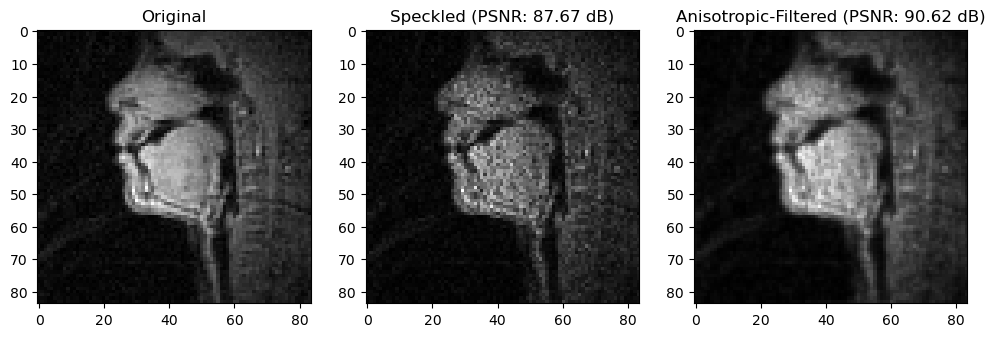

In [7]:
noise_psnr = psnr(rec_data, speckle_data)
anfilt_psnr = psnr(rec_data, anis_filt)

_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(rec_data[3000].T, cmap='gray'), ax[0].set_title('Original')
ax[1].imshow(speckle_data[3000].T, cmap='gray'), ax[1].set_title('Speckled (PSNR: {:.2f} dB)'.format(noise_psnr))
ax[2].imshow(anis_filt[3000].T, cmap='gray'), ax[2].set_title('Anisotropic-Filtered (PSNR: {:.2f} dB)'.format(anfilt_psnr))
plt.show()

In [43]:
bm3d_filt = bm3d.bm3d(speckle_data[0], sigma_psd=0.000118, stage_arg=bm3d.BM3DStages.ALL_STAGES)


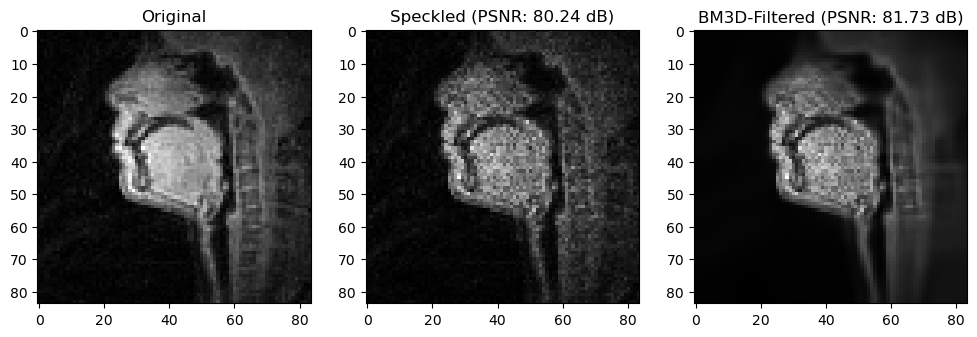

In [44]:
noise_psnr = psnr(rec_data[0], speckle_data[0])
bm3d_psnr = psnr(rec_data[0], bm3d_filt)
# ONLY ONE IMAGE
_, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(rec_data[0].T, cmap='gray'), ax[0].set_title('Original')
ax[1].imshow(speckle_data[0].T, cmap='gray'), ax[1].set_title('Speckled (PSNR: {:.2f} dB)'.format(noise_psnr))
ax[2].imshow(bm3d_filt.T, cmap='gray'), ax[2].set_title('BM3D-Filtered (PSNR: {:.2f} dB)'.format(bm3d_psnr))
plt.show()